## COVID19 Forecasting Project

**ECE 685:** Deep Learning <br>
**Student:** Guillem Amat, Sebastian Soriano

<br>

#### Loading Packages

In [198]:
# Normal Packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import pdb
import csv
import os

In [199]:
# Torch Packages
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

<br>

#### Loading Data

In [200]:
import warnings
warnings.filterwarnings("ignore")

In [201]:
PATH = r'C:\Users\guill\Desktop\Final Project'
os.chdir(PATH)

In [202]:
data = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'week_5', 'train.csv'))

<br>

**Creating Key for Location**

In [203]:
data.head()

,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue
0,1,NaN,NaN,Afghanistan,27657145,0.058359,1/23/2020,ConfirmedCases,0
1,2,NaN,NaN,Afghanistan,27657145,0.583587,1/23/2020,Fatalities,0
2,3,NaN,NaN,Afghanistan,27657145,0.058359,1/24/2020,ConfirmedCases,0
3,4,NaN,NaN,Afghanistan,27657145,0.583587,1/24/2020,Fatalities,0
4,5,NaN,NaN,Afghanistan,27657145,0.058359,1/25/2020,ConfirmedCases,0


In [204]:
data['County']         = data['County'].fillna('')
data['Province_State'] = data['Province_State'].fillna('')

In [205]:
data['location'] = data['Country_Region'] + ' ' + data['Province_State'] + ' ' + data['County']

In [206]:
population = data[['location', 'Population']].drop_duplicates()

<br>

**Filtering Country**

In [876]:
#!pip install us
#!pip install countrygroups

In [207]:
from countrygroups import EUROPEAN_UNION
#from us import states

In [208]:
euro = ['Spain', 'Germany', 'France', 'Italy', 'United Kingdom']

In [209]:
european = EUROPEAN_UNION.names
#american = [str(state) for state in states.STATES]

In [210]:
# Operations to subset for european countries
data = data[data['Country_Region'].isin(euro)]
data = data.loc[lambda x: x.Province_State == '']

In [105]:
data = data[data['Country_Region']=='Spain']

<br>

**Pivoting Data**

In [211]:
data = data.pivot(index=['location', 'Date'], columns='Target', values='TargetValue')

In [212]:
data = data.reset_index()

<br>

**Joining Latitude and Longitude**

In [213]:
coordinates = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'other', 'coordinates.csv'))

In [214]:
coordinates.head()

,Location,Longitude,Latitude
0,Afghanistan,66.238514,33.768006
1,Albania,19.999962,41.000028
2,Algeria,2.999983,28.000027
3,Andorra,1.573203,42.540717
4,Angola,17.569124,-11.877577


In [215]:
df = data.merge(coordinates, how='inner', left_on='location', right_on='Location')
data = df.merge(population, how='left', left_on='location', right_on='location')

In [216]:
data = data.drop(['Location', 'location', 'Date'], axis = 1)

In [217]:
data.head()

,ConfirmedCases,Fatalities,Longitude,Latitude,Population
0,0,0,1.888333,46.603354,66710000
1,2,0,1.888333,46.603354,66710000
2,1,0,1.888333,46.603354,66710000
3,0,0,1.888333,46.603354,66710000
4,0,0,1.888333,46.603354,66710000


<br>

**Scaling Variables**

In [218]:
# Scaling Variables
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler = scaler.fit(data)
scaled_data = scaler.transform(data)

<br>

**Creating Numpy Array**

In [221]:
dataset = np.array(scaled_data).reshape(-1, 140, 5)
train = dataset[:, :95, :]
test  = dataset[:, 95:, :]

<br>

**Creating Sequences**

In [228]:
def create_sequences(data, seq_length, n_features=2):
    
    X = np.zeros((data.shape[0], data.shape[1] -seq_length -1, seq_length, data.shape[2]))
    Y = np.zeros((data.shape[0], data.shape[1] -seq_length -1, n_features))
    
    for batch in range(X.shape[0]):
        
        xs = []; ys = []
        country = data[batch]
        
        for i in range(len(country) -seq_length -1):
            x = data[batch][i:(i+seq_length)]
            y = data[batch][i+seq_length]
            xs.append(x)
            ys.append(y)
            
        #pdb.set_trace()
        X[batch, :, :, :] = np.array(xs)
        Y[batch, :,  :]   = np.array(ys)[:, :2]
        
    return X, Y

In [229]:
seq_length = 25
X_train, y_train = create_sequences(train, seq_length=seq_length, n_features=2)
X_test,  y_test  = create_sequences(test, seq_length=seq_length, n_features=2)

In [230]:
X_train, y_train = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()
X_test, y_test = torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()

In [231]:
trainset = torch.utils.data.TensorDataset(X_train, y_train)
testset  = torch.utils.data.TensorDataset(X_test, y_test)

In [232]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True)
testloader  = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

<br>

### Modeling

In [233]:
torch.set_default_tensor_type(torch.FloatTensor)

<br>

**Save Model**

In [234]:
def path_model(model):
    PATH1 = os.path.join(os.getcwd(), 'Models', f'{model}_model')
    PATH2 = os.path.join(os.getcwd(), 'Models', f'{model}_state_dictionary')
    return PATH1, PATH2

<br>

**Predict on Test**

In [333]:
dset, _ = create_sequences(dataset, seq_length=25)
dset = torch.from_numpy(dset).float()

In [356]:
final = dset[4,-45:,:]
predictions = lstm(final)

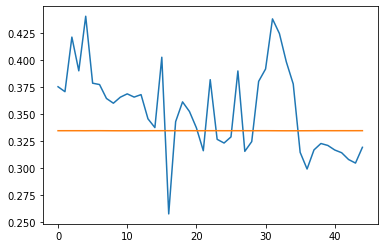

In [357]:
plt.plot(dataset[4][-45:, 0])
plt.plot(predictions[:, 0].detach().numpy())

In [343]:
final_train = dset[2,:-45,:]
predictions_train = lstm(final)

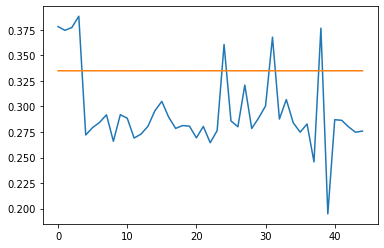

In [344]:
plt.plot(dataset[0][-45:, 0])
plt.plot(predictions_train[:, 0].detach().numpy())

<br>

**Training**

In [329]:
def train_model(model: torch.nn.Module, train: torch.utils.data.DataLoader, test: torch.utils.data.DataLoader, epochs: int, net):
    
    #Initializing Variables to store information
    min_loss   = float('inf')
    train_loss = 0
    test_loss  = 0
    train_history = []
    test_history  = []
    
    for epoch in range(epochs):
        
        train_loss = 0
        test_loss  = 0
    
        model.train()
        for _, data in enumerate(train):
        
            model.reset_hidden_state()
            optimizer.zero_grad()
            
            X_train, y_train = data
            X_train, y_train = Variable(torch.squeeze(X_train)), Variable(torch.squeeze(y_train))
            y_hat = model(X_train)
            
            loss  = criterion(y_hat, y_train)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() 
            
        train_history.append(train_loss)
        
        model.eval()
        for _, data in enumerate(test):
            
            X_test, y_test = data
            X_test, y_test = torch.squeeze(X_test), torch.squeeze(y_test)
            y_hat = model(X_test)
            
            test_loss += criterion(y_hat, y_test).item() 
       
        test_history.append(test_loss)
        
        train_loss     = str(train_loss/len(train.dataset))[:4]
        test_loss      = test_loss/len(test.dataset)
        
        if test_loss < min_loss:
            min_test_loss = test_loss
            
            #Save Model
            path1, path2 = path_model(net)
            torch.save(model, path1)
            torch.save(model.state_dict(), path2)
        
        if epoch == 0:
            string = f'''| Epoch: {epoch + 1}   | Train Loss: {train_loss} | Test Loss: {str(test_loss)[:4]} |'''
            print('-'*len(string)); print(string); print('-'*len(string))
    
        #elif ((epoch + 1) % 100 == 0) & (epoch < 100):
        #    string = f'''| Epoch: {epoch + 1}  | Train Loss: {train_loss} | Test Loss: {str(test_loss)[:4]} |'''
        #    print(string); print('-'*len(string))
            
        elif ((epoch + 1) % 100 == 0) & (epoch >= 100):
            string = f'''| Epoch: {epoch + 1} | Train Loss: {train_loss} | Test Loss: {str(test_loss)[:4]} |'''
            print(string); print('-'*len(string))
        
    return model.eval(), train_history, test_history

<br>

#### Artificial Neural Network

<br>

#### Convolutional Neural Network

<br>

#### Recurrent Neural Network

torch.Size([28, 69, 25, 5])

<br>

#### Gated Recurrent Unit

In [263]:
class GRU(nn.Module):
    def __init__(self, n_input, n_hidden, n_output, seq_len, n_layers=2):
        super().__init__()
        #pdb.set_trace()
        self.n_hidden   = n_hidden
        self.seq_len    = seq_len
        self.n_layers   = n_layers
        
        self.gru = nn.GRU(n_input, n_hidden, n_layers, dropout=0.01)
        self.fc  = nn.Linear(n_hidden, n_output)
        
    def forward(self, x):
        #pdb.set_trace()
        gru_out, self.hidden = self.gru(x.view(len(x), self.seq_len, -1), self.hidden)
        last_time_step = gru_out.reshape(self.seq_len, len(x), self.n_hidden)[-1]
        out    = self.fc(last_time_step)
        return out
    
    def reset_hidden_state(self):
        self.hidden = torch.zeros(self.n_layers, self.seq_len, self.n_hidden)

In [264]:
criterion = torch.nn.MSELoss(reduction='sum')
model     = GRU(n_input=5, n_hidden=512, seq_len=25, n_output=2, n_layers=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00025)

In [265]:
gru, train_history, test_history = train_model(model, trainloader, testloader, 100, net='GRU')

---------------------------------------------------
| Epoch: 1   | Train Loss: 25.0 | Test Loss: 0.73 |
---------------------------------------------------
| Epoch: 10  | Train Loss: 1.00 | Test Loss: 0.08 |
---------------------------------------------------
| Epoch: 20  | Train Loss: 0.96 | Test Loss: 0.07 |
---------------------------------------------------
| Epoch: 30  | Train Loss: 0.97 | Test Loss: 0.07 |
---------------------------------------------------
| Epoch: 40  | Train Loss: 0.96 | Test Loss: 0.07 |
---------------------------------------------------
| Epoch: 50  | Train Loss: 0.96 | Test Loss: 0.08 |
---------------------------------------------------
| Epoch: 60  | Train Loss: 0.96 | Test Loss: 0.08 |
---------------------------------------------------
| Epoch: 70  | Train Loss: 0.95 | Test Loss: 0.08 |
---------------------------------------------------
| Epoch: 80  | Train Loss: 0.96 | Test Loss: 0.08 |
---------------------------------------------------
| Epoch: 90 

(0, 125)

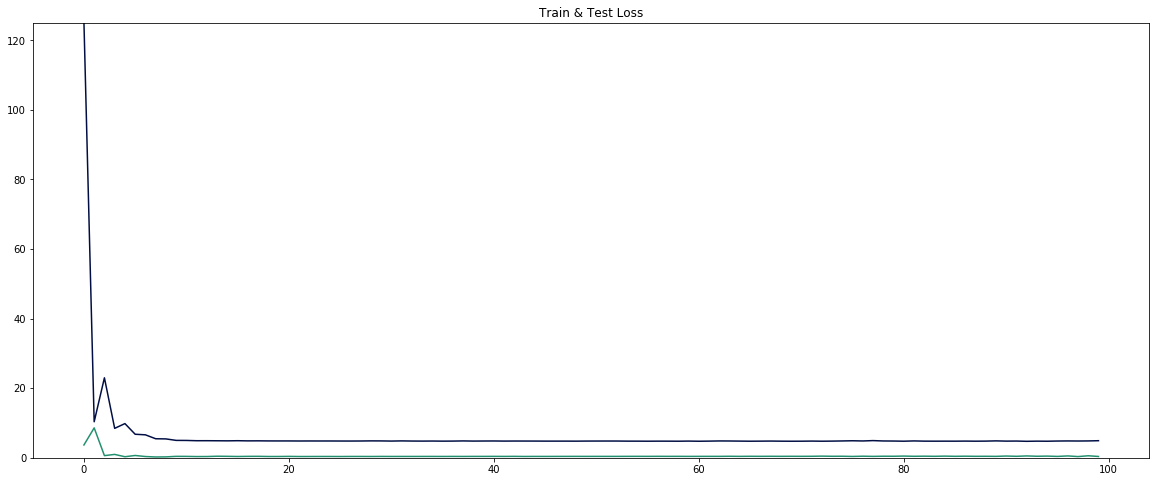

In [271]:
plt.figure(figsize=(20, 8))

plt.title('Train & Test Loss')
plt.plot(train_history, color='#000E43', label = 'Confirmed Cases')
plt.plot(test_history, color='#22906F', label = 'Fatalities')
plt.ylim((0, 125))

<br>

#### Long-Short Term Memory

In [330]:
class LSTM(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super().__init__()
        self.n_hidden = n_hidden
        self.seq_len  = seq_len
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_size=n_features,
                            hidden_size=n_hidden,
                            num_layers=n_layers,
                            dropout=0.01)
        
        self.linear = nn.Linear(in_features=n_hidden, out_features=2)
     
    def reset_hidden_state(self):
        self.hidden = (torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                       torch.zeros(self.n_layers, self.seq_len, self.n_hidden))
            
    def forward(self, sequences):
        #pdb.set_trace()
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1),
                                          self.hidden)
            
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        out = self.linear(last_time_step)
        return out  

In [331]:
criterion = torch.nn.MSELoss(reduction='sum')
model     = LSTM(n_features=5, n_hidden=512, seq_len=25, n_layers=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00125)

In [332]:
lstm, train_history, test_history = train_model(model, trainloader, testloader, 2500, net = 'LSTM')

---------------------------------------------------
| Epoch: 1   | Train Loss: 165. | Test Loss: 1.23 |
---------------------------------------------------
| Epoch: 200 | Train Loss: 0.94 | Test Loss: 0.11 |
---------------------------------------------------
| Epoch: 300 | Train Loss: 0.94 | Test Loss: 0.11 |
---------------------------------------------------
| Epoch: 400 | Train Loss: 0.94 | Test Loss: 0.12 |
---------------------------------------------------
| Epoch: 500 | Train Loss: 0.93 | Test Loss: 0.13 |
---------------------------------------------------
| Epoch: 600 | Train Loss: 0.93 | Test Loss: 0.13 |
---------------------------------------------------
| Epoch: 700 | Train Loss: 0.92 | Test Loss: 0.14 |
---------------------------------------------------
| Epoch: 800 | Train Loss: 0.90 | Test Loss: 0.16 |
---------------------------------------------------
| Epoch: 900 | Train Loss: 0.91 | Test Loss: 0.11 |
---------------------------------------------------
| Epoch: 100

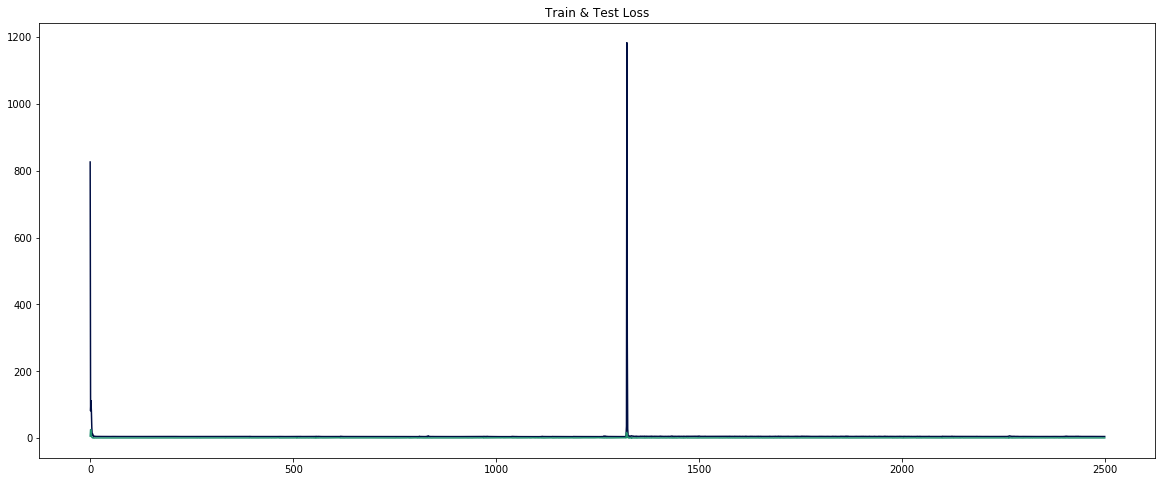

In [347]:
plt.figure(figsize=(20, 8))

plt.title('Train & Test Loss')
plt.plot(train_history, color='#000E43', label = 'Train Data')
plt.plot(test_history, color='#22906F', label = 'Test Data')
#plt.ylim((0, 125))